In [8]:
import os
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Jupyter Magic to make plots show up inline
%matplotlib inline

import gymnasium as gym
import gym4real
from gym4real.envs.wds.utils import parameter_generator
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

import wntr
import wntr.sim

# Force the Python simulator to prevent M3 Kernel Crashes
print("🔧 Patching WNTR Simulator for M3 Compatibility...")
wntr.sim.EpanetSimulator = wntr.sim.WNTRSimulator

🔧 Patching WNTR Simulator for M3 Compatibility...


In [9]:
config_path = os.path.join(os.getcwd(), "gym4real", "envs", "wds", "world_anytown.yaml")

DURATION_STEPS = 168 

base_params = parameter_generator(
    world_options=config_path, 
    hydraulic_step=3600,       # 1 hour steps
    duration=3600 * 24 * 7,    # 7 days in seconds
    seed=42)

def make_env():
    params = copy.deepcopy(base_params)
    env = gym.make('gym4real/wds-v0', settings=params)
    return env

# CREATE TRAINING ENVIRONMENT
# We use n_envs=1 for stability
train_env = DummyVecEnv([make_env])
train_env = VecMonitor(train_env)

/Users/kavish/miniforge3/envs/rl/lib/python3.10/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/kavish/miniforge3/envs/rl/lib/python3.10/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [10]:
MODEL_NAME = "DQN_WDS_M3"

print("🧠 Initializing DQN Agent...")
model = DQN(
    "MlpPolicy", 
    train_env, 
    learning_rate=1e-4,
    buffer_size=10000,
    learning_starts=1000,
    batch_size=32,
    device="cpu", 
    verbose=1)

print(f"Training {MODEL_NAME}...")
model.learn(total_timesteps=10000) # Increase this for better results
print("✅ Training Complete.")

# Save the model
model.save(MODEL_NAME)

🧠 Initializing DQN Agent...
Using cpu device
Training DQN_WDS_M3...
Resetting the environment...
Resetting the environment...
Resetting the environment...
Resetting the environment...
Resetting the environment...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.08e+03 |
|    ep_rew_mean      | 756      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 32       |
|    time_elapsed     | 133      |
|    total_timesteps  | 4313     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0141   |
|    n_updates        | 828      |
----------------------------------
Resetting the environment...
Resetting the environment...
Resetting the environment...
Resetting the environment...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.07e+03 |
|    ep_rew_mean      | 738      |
|    e

In [11]:
# --- EVALUATION CONFIG ---
N_EVAL_EPISODES = 20      # Run 20 
STEPS_PER_EPISODE = 168  # 7 days (1 step per hour)

print(f"Evaluating over {N_EVAL_EPISODES} episodes...")

# Create a fresh environment for evaluation (clean slate)
eval_env = make_env()

all_episode_rewards = []
all_step_rewards = [] # To store the curve of each episode

for episode in range(1, N_EVAL_EPISODES + 1):
    obs, _ = eval_env.reset()
    done = False
    truncated = False
    episode_reward = 0
    step_rewards = []
    
    for step in range(STEPS_PER_EPISODE):
        action, _ = model.predict(obs, deterministic=True)          # Predict action (Deterministic = True removes randomness for evaluation)
        
        obs, reward, terminated, truncated, info = eval_env.step(action)
        
        episode_reward += reward
        step_rewards.append(reward)
        
        if terminated or truncated:
            break
            
    all_episode_rewards.append(episode_reward)
    all_step_rewards.append(step_rewards)
    print(f"   Episode {episode}: Total Reward = {episode_reward:.2f}")

eval_env.close()

# --- CALCULATE STATISTICS ---
avg_total_reward = np.mean(all_episode_rewards)
std_total_reward = np.std(all_episode_rewards)

# Average the reward curve across all episodes for a smooth graph
# (Transpose list of lists -> calculate mean across axis 0)
avg_curve = np.mean(all_step_rewards, axis=0)

print(f"Average Total Reward: {avg_total_reward:.2f} +/- {std_total_reward:.2f}")

Evaluating over 20 episodes...
Resetting the environment...


/Users/kavish/miniforge3/envs/rl/lib/python3.10/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/kavish/miniforge3/envs/rl/lib/python3.10/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


   Episode 1: Total Reward = 100.77
Resetting the environment...
   Episode 2: Total Reward = 133.55
Resetting the environment...
   Episode 3: Total Reward = 99.41
Resetting the environment...
   Episode 4: Total Reward = 113.98
Resetting the environment...
   Episode 5: Total Reward = 131.34
Resetting the environment...
   Episode 6: Total Reward = 118.56
Resetting the environment...
   Episode 7: Total Reward = 131.19
Resetting the environment...
   Episode 8: Total Reward = 86.84
Resetting the environment...
   Episode 9: Total Reward = 127.80
Resetting the environment...
   Episode 10: Total Reward = 148.51
Resetting the environment...
   Episode 11: Total Reward = 113.34
Resetting the environment...
   Episode 12: Total Reward = 88.63
Resetting the environment...
   Episode 13: Total Reward = 133.46
Resetting the environment...


/Users/kavish/Documents/gym4real/gym4real/envs/wds/simulator/epynet/epanet2.py:683: UserWarning: WARNING: Pumps cannot deliver enough flow or head.
  warnings.warn(self.ENgeterror(ierr))


   Episode 14: Total Reward = 86.55
Resetting the environment...
   Episode 15: Total Reward = 167.57
Resetting the environment...
   Episode 16: Total Reward = 80.27
Resetting the environment...
   Episode 17: Total Reward = 95.62
Resetting the environment...
   Episode 18: Total Reward = 117.80
Resetting the environment...
   Episode 19: Total Reward = 114.16
Resetting the environment...
   Episode 20: Total Reward = 108.48
Average Total Reward: 114.89 +/- 21.97


💾 Graph saved to: DQN_WDS_M3_graph.png


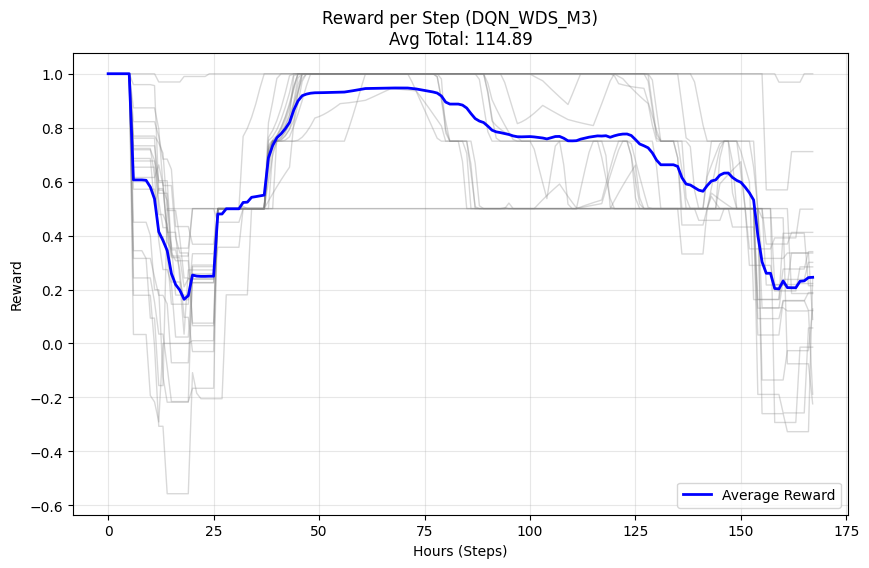

In [12]:
# --- PLOTTING ---
plt.figure(figsize=(10, 6))

# Plot individual runs transparently
for run in all_step_rewards:
    plt.plot(run, color='gray', alpha=0.3, linewidth=1)

# Plot the average line boldly
plt.plot(avg_curve, color='blue', linewidth=2, label='Average Reward')

plt.title(f"Reward per Step ({MODEL_NAME})\nAvg Total: {avg_total_reward:.2f}")
plt.xlabel("Hours (Steps)")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the graph
save_filename = f"{MODEL_NAME}_graph.png"
plt.savefig(save_filename, dpi=300)
print(f"💾 Graph saved to: {save_filename}")

plt.show()